### Exploring Depression Patterns Using K-Means Clustering

This notebook applies **K-Means clustering** to identify patterns in depression severity and related characteristics using NHANES data from 2021 to 2023. The objective is to uncover natural groupings of individuals based on health, behavioral, and demographic features without relying on predefined labels.

Unsupervised learning offers a way to examine latent structure in the dataset. Clustering can reveal whether meaningful subgroups emerge and provide insight into how combinations of variables may relate to depression severity.

The dataset has been fully cleaned and encoded. Adult respondents with valid data across selected modules were retained. Categorical variables were encoded according to their measurement levels (*binary*, *ordinal*, or *nominal*), and continuous variables were preserved as-is.

Before applying any clustering algorithm, it is essential to confirm that all features are numeric and ready for transformation.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

# Load cleaned dataset from the appropriate relative path
df = pd.read_csv("../data/clean/merged_clean.csv")

# Display shape and data types
print(f"Dataset shape: {df.shape}\n")
print("Column data types:\n")
print(df.dtypes)

# Check if all columns are technically numeric
if all(pd.api.types.is_numeric_dtype(dtype) for dtype in df.dtypes):
    print("\nAll columns are numeric. Proceed to review encoding before scaling.")
else:
    print("\nSome columns are non-numeric and may need to be re-encoded.")


Dataset shape: (467, 26)

Column data types:

Gender                                      float64
Age in years at screening                   float64
Education level - Adults 20+                float64
Total number of people in the Household     float64
Difficulty these problems have caused       float64
Difficulty with self-care                   float64
How often feel worried/nervous/anxious      float64
Level of feeling worried/nervous/anxious    float64
Covered by health insurance                 float64
Covered by private insurance                float64
Covered by Medicare                         float64
Covered by Medi-Gap                         float64
Covered by Medicaid                         float64
Covered by CHIP                             float64
Covered by military health care             float64
Covered by state-sponsored health plan      float64
Covered by other government insurance       float64
Time when no insurance in past year?        float64
Routine place to g

### One-Hot Encoding for Nominal Variables

To prepare the dataset for K-Means clustering, one-hot encoding is applied to nominal categorical variables. These features are not ordinal and must be expanded into binary columns so they are interpreted correctly in distance-based clustering.

The following variables were one-hot encoded:

- Covered by private insurance  
- Covered by Medicare  
- Covered by Medi-Gap  
- Covered by Medicaid  
- Covered by military health care  
- Covered by state-sponsored health plan  
- Time when no insurance in past year?  
- Routine place to go for healthcare  
- Type place most often go for healthcare  
- Past 12 months had video conf w/Dr?  
- Seen mental health professional/past yr

Two variables were dropped because they contained no valid responses:

- Covered by CHIP  
- Covered by other government insurance


In [2]:
# Drop variables with no responses
df = df.drop(columns=[
    'Covered by CHIP',
    'Covered by other government insurance'
])

# Define nominal variables to one-hot encode
nominal_vars = [
    'Covered by private insurance',
    'Covered by Medicare',
    'Covered by Medi-Gap',
    'Covered by Medicaid',
    'Covered by military health care',
    'Covered by state-sponsored health plan',
    'Time when no insurance in past year?',
    'Routine place to go for healthcare',
    'Type place most often go for healthcare',
    'Past 12 months had video conf w/Dr?',
    'Seen mental health professional/past yr'
]

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=nominal_vars, drop_first=False, dtype=int)

# Confirm shape and sample
print(f"Encoded dataset shape: {df_encoded.shape}")
df_encoded.head()


Encoded dataset shape: (467, 33)


,Gender,Age in years at screening,Education level - Adults 20+,Total number of people in the Household,Difficulty these problems have caused,Difficulty with self-care,How often feel worried/nervous/anxious,Level of feeling worried/nervous/anxious,Covered by health insurance,Monthly poverty index,...,Type place most often go for healthcare_1.0,Type place most often go for healthcare_2.0,Type place most often go for healthcare_3.0,Type place most often go for healthcare_4.0,Type place most often go for healthcare_5.0,Type place most often go for healthcare_6.0,Past 12 months had video conf w/Dr?_1.0,Past 12 months had video conf w/Dr?_2.0,Seen mental health professional/past yr_1.0,Seen mental health professional/past yr_2.0
0,2.0,33.0,3.0,3.0,2.0,1.0,1.0,2.0,1.0,0.94,...,1,0,0,0,0,0,0,1,0,1
1,2.0,67.0,3.0,2.0,NaN,1.0,1.0,3.0,1.0,3.28,...,1,0,0,0,0,0,0,1,0,1
2,1.0,67.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,NaN,...,1,0,0,0,0,0,0,1,0,1
3,2.0,38.0,5.0,1.0,1.0,1.0,1.0,3.0,1.0,5.00,...,1,0,0,0,0,0,1,0,1,0
4,2.0,66.0,4.0,4.0,1.0,1.0,1.0,2.0,2.0,NaN,...,0,0,0,0,0,0,0,1,0,1


### Handling Missing Values

To address missing values, we prepare two versions of the dataset for analysis:

- **Drop version**: Rows with any missing values are removed.
- **Imputed version**: Missing values are filled using simple imputation strategies:
  - *Median* for continuous and ordinal variables  
  - *Mode* for binary and nominal variables

This dual approach allows for a comparison of cluster robustness under different missing data strategies.


In [3]:
# Create a copy for dropping missing values
df_drop = df_encoded.dropna().copy()

# Create a copy for imputation
df_impute = df_encoded.copy()

# Identify columns with missing values
missing_cols = df_impute.columns[df_impute.isnull().any()]

# Impute using median (safe for both ordinal and continuous)
for col in missing_cols:
    df_impute[col] = df_impute[col].fillna(df_impute[col].median())

print(f"Drop version shape: {df_drop.shape}")
print(f"Imputed version shape: {df_impute.shape}")


Drop version shape: (273, 33)
Imputed version shape: (467, 33)


### Scaling the Data

K-Means is sensitive to the magnitude of input features. To ensure all variables contribute equally to the clustering process, we apply **standardization** using `StandardScaler`.

Each version of the dataset—*drop* and *imputed*—is scaled separately. Standardization transforms each feature to have a mean of 0 and a standard deviation of 1, making distance calculations more reliable during clustering.


In [4]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the drop version
X_drop_scaled = scaler.fit_transform(df_drop)

# Scale the imputed version
X_impute_scaled = scaler.fit_transform(df_impute)

# Confirm shapes match original
print(f"Scaled drop version shape: {X_drop_scaled.shape}")
print(f"Scaled imputed version shape: {X_impute_scaled.shape}")


Scaled drop version shape: (273, 33)
Scaled imputed version shape: (467, 33)


### What Is a Cluster and Why Does It Matter Here?

In K-Means clustering, a **cluster** is a group of observations that are more similar to each other than to those in other groups, based on a chosen set of features. The algorithm assigns individuals to clusters by minimizing the distance between each point and the center of its assigned group.

This matters because clustering can reveal hidden structure in the data. For this project, we are exploring whether certain combinations of demographic, behavioral, and healthcare-related characteristics tend to co-occur among adults at different levels of depression risk.

The goal is not to predict depression, but to better understand which subgroups emerge naturally from the data—and whether these subgroups align with meaningful differences in mental health, access to care, or socioeconomic status.


### Selecting the Number of Clusters

Choosing a suitable number of clusters (**k**) is a critical step in K-Means. We evaluate multiple values of *k* using:

- **Elbow Method**: Plots the within-cluster sum of squares (inertia). A noticeable “elbow” suggests a good trade-off between complexity and performance.
- **Silhouette Score**: Measures how similar points are to their own cluster versus other clusters. Higher values indicate better-defined clusters.

Both metrics will be computed for:

- The **scaled drop version**
- The **scaled imputed version**

This helps assess cluster consistency across different handling of missing values.


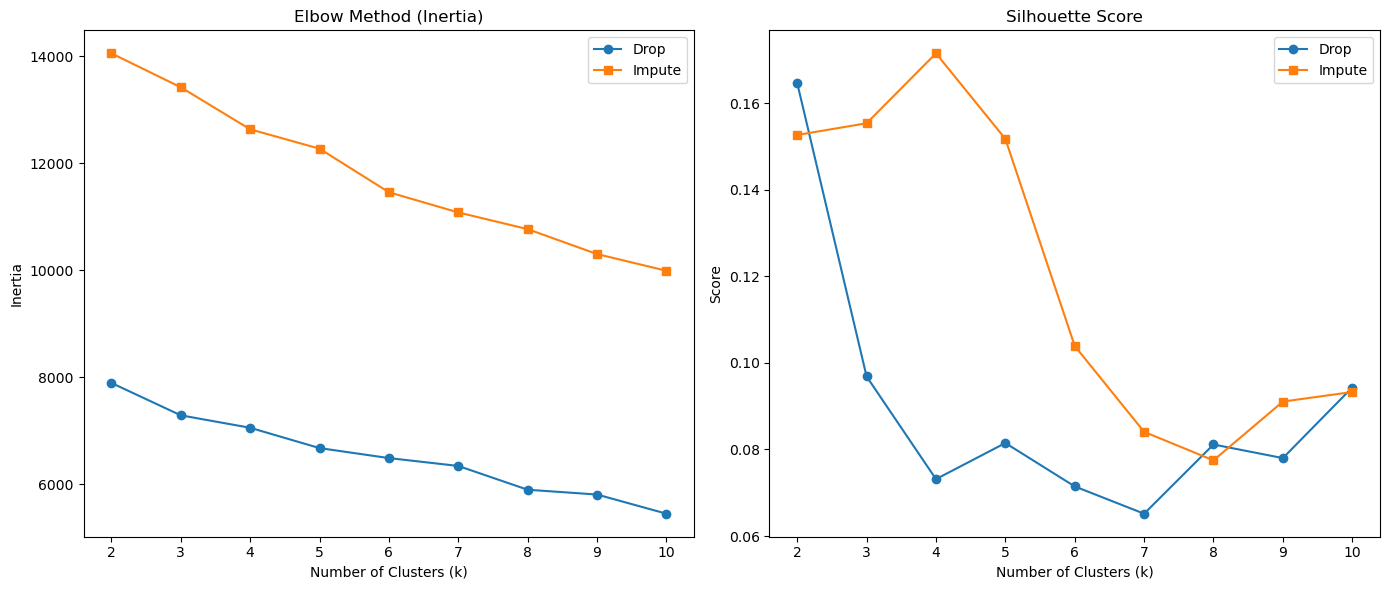

In [5]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set range for k
k_range = range(2, 11)

# Elbow and silhouette lists
inertia_drop = []
silhouette_drop = []
inertia_impute = []
silhouette_impute = []

# Loop through values of k
for k in k_range:
    # Drop version
    kmeans_drop = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels_drop = kmeans_drop.fit_predict(X_drop_scaled)
    inertia_drop.append(kmeans_drop.inertia_)
    silhouette_drop.append(silhouette_score(X_drop_scaled, labels_drop))
    
    # Imputed version
    kmeans_impute = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels_impute = kmeans_impute.fit_predict(X_impute_scaled)
    inertia_impute.append(kmeans_impute.inertia_)
    silhouette_impute.append(silhouette_score(X_impute_scaled, labels_impute))

# Plotting
plt.figure(figsize=(14, 6))

# Elbow plot
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia_drop, marker='o', label='Drop')
plt.plot(k_range, inertia_impute, marker='s', label='Impute')
plt.title("Elbow Method (Inertia)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.legend()

# Silhouette plot
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_drop, marker='o', label='Drop')
plt.plot(k_range, silhouette_impute, marker='s', label='Impute')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()


### Interpreting Cluster Selection Metrics

The **Elbow Method** (left plot) shows a gradual decline in inertia with no dramatic drop at any single point. However, mild bends appear near:

- **k = 4 or 5** for the *drop version*
- **k = 4 to 6** for the *imputed version*

The **Silhouette Score** (right plot) provides more contrast. Peaks in score suggest better-defined clusters:

- For the *drop version*, the highest score occurs at **k = 2**, but this may be too coarse to capture variation in depression profiles.
- For the *imputed version*, **k = 4** produces the highest silhouette score, followed by **k = 3** and **k = 5**.

While k = 2 technically scores best for drop, it may oversimplify. Choosing **k = 4 or 5** strikes a balance between interpretability and separation, and provides a common ground across both versions.

These candidate values will be used in subsequent K-Means clustering and visualization steps.


In [6]:
# Fit KMeans with k = 4
kmeans_drop = KMeans(n_clusters=4, random_state=42, n_init='auto')
labels_drop = kmeans_drop.fit_predict(X_drop_scaled)

kmeans_impute = KMeans(n_clusters=4, random_state=42, n_init='auto')
labels_impute = kmeans_impute.fit_predict(X_impute_scaled)

# Add cluster labels to the original (unscaled) datasets
df_drop_labeled = df_drop.copy()
df_drop_labeled["Cluster_ID"] = labels_drop

df_impute_labeled = df_impute.copy()
df_impute_labeled["Cluster_ID"] = labels_impute

# Confirm label assignment
print("Cluster counts (drop version):")
print(df_drop_labeled["Cluster_ID"].value_counts().sort_index(), "\n")

print("Cluster counts (imputed version):")
print(df_impute_labeled["Cluster_ID"].value_counts().sort_index())


Cluster counts (drop version):
Cluster_ID
0    77
1    88
2    59
3    49
Name: count, dtype: int64 

Cluster counts (imputed version):
Cluster_ID
0     44
1    348
2     59
3     16
Name: count, dtype: int64


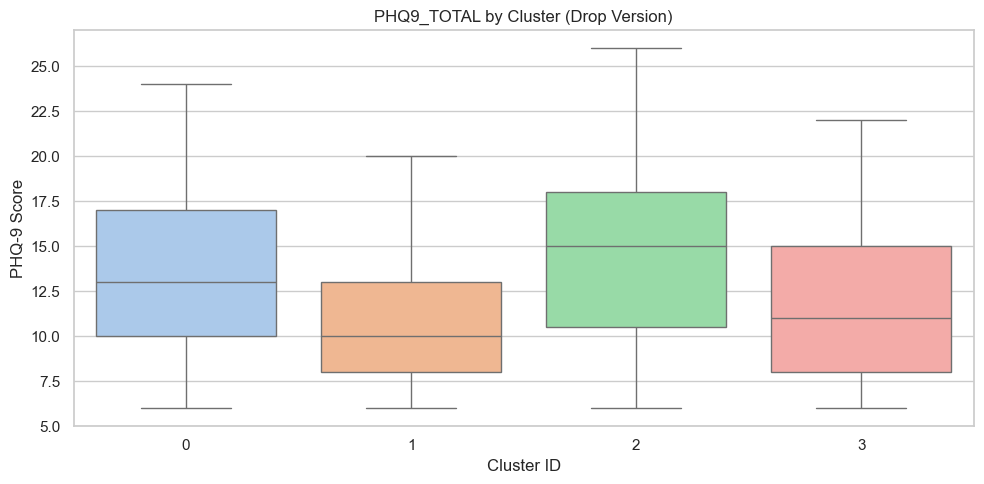

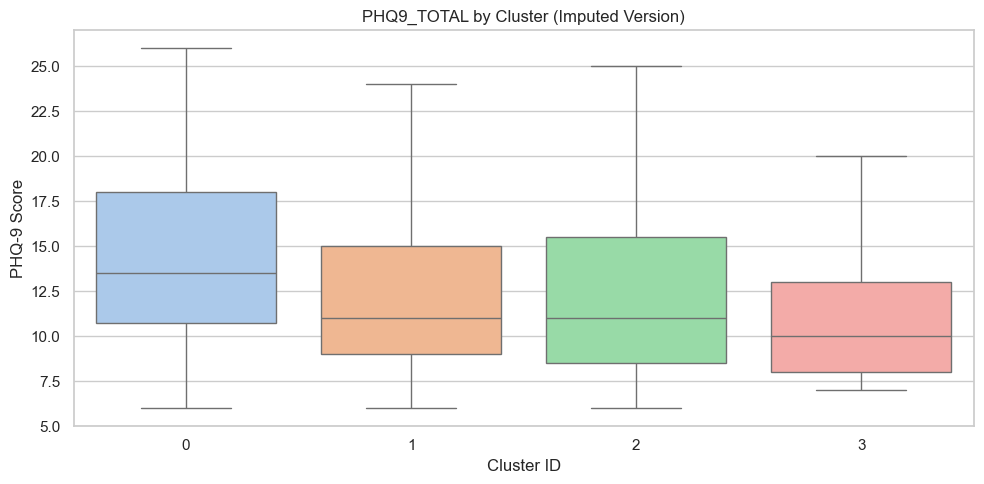

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Drop version
plt.figure(figsize=(10, 5))
sns.boxplot(x="Cluster_ID", y="PHQ9_TOTAL", data=df_drop_labeled, palette="pastel")
plt.title("PHQ9_TOTAL by Cluster (Drop Version)")
plt.xlabel("Cluster ID")
plt.ylabel("PHQ-9 Score")
plt.tight_layout()
plt.show()

# Imputed version
plt.figure(figsize=(10, 5))
sns.boxplot(x="Cluster_ID", y="PHQ9_TOTAL", data=df_impute_labeled, palette="pastel")
plt.title("PHQ9_TOTAL by Cluster (Imputed Version)")
plt.xlabel("Cluster ID")
plt.ylabel("PHQ-9 Score")
plt.tight_layout()
plt.show()


### *PHQ-9 Scores Across Clusters*

The PHQ-9 boxplots help assess how depression severity differs between the clusters identified by K-Means.

In both versions, the clusters show variation in PHQ-9 score distributions. Some clusters contain individuals with consistently higher median scores, while others lean lower or are more mixed.

- **Drop version:** Cluster 2 appears to have the highest median PHQ-9 scores, followed by Cluster 0. Cluster 1 shows a tighter range around lower values, while Cluster 3 is more balanced.
- **Imputed version:** Cluster 0 also shows the highest PHQ-9 median and wider spread. Cluster 3 appears to group those with lower severity scores. The overall structure is similar to the drop version, though imputation slightly shifts the distribution ranges.

These patterns suggest that K-Means may be capturing subgroups with differing levels of depression risk, validating its use in feature profiling. While cluster boundaries aren’t perfectly clean, the distributions reflect enough contrast to support further investigation of feature composition within each group.


In [8]:
# Compute mean values by cluster
drop_profile = df_drop_labeled.groupby("Cluster_ID").mean(numeric_only=True)
impute_profile = df_impute_labeled.groupby("Cluster_ID").mean(numeric_only=True)

# Display tables 
print("Drop Version: Feature Means by Cluster\n")
display(drop_profile.round(2).iloc[:, :10])  # show first 10 columns

print("\nImputed Version: Feature Means by Cluster\n")
display(impute_profile.round(2).iloc[:, :10])  # show first 10 columns


Drop Version: Feature Means by Cluster



,Gender,Age in years at screening,Education level - Adults 20+,Total number of people in the Household,Difficulty these problems have caused,Difficulty with self-care,How often feel worried/nervous/anxious,Level of feeling worried/nervous/anxious,Covered by health insurance,Monthly poverty index
Cluster_ID,,,,,,,,,,
0,1.70,46.90,3.99,2.21,1.53,1.34,1.32,2.49,1.00,2.09
1,1.53,53.86,4.00,2.11,1.11,1.18,2.05,2.47,1.00,3.03
2,1.83,49.61,3.19,2.54,1.41,1.31,1.47,2.42,1.02,1.08
3,1.41,36.90,3.51,2.31,1.27,1.20,1.49,2.39,1.51,2.39



Imputed Version: Feature Means by Cluster



,Gender,Age in years at screening,Education level - Adults 20+,Total number of people in the Household,Difficulty these problems have caused,Difficulty with self-care,How often feel worried/nervous/anxious,Level of feeling worried/nervous/anxious,Covered by health insurance,Monthly poverty index
Cluster_ID,,,,,,,,,,
0,1.48,53.07,3.09,2.41,1.32,1.41,2.09,2.34,1.20,1.41
1,1.67,47.86,3.74,2.37,1.29,1.23,1.81,2.49,1.05,2.22
2,1.46,34.59,3.90,2.47,1.29,1.17,1.58,2.41,1.44,2.46
3,1.12,60.69,3.50,2.31,1.25,1.19,2.12,2.69,1.00,2.62


### Interpreting Clusters by Feature Profile

The cluster summaries highlight how feature patterns align with differences in PHQ-9 depression scores.

- In the **drop version**, Cluster 2 shows the highest PHQ-9 scores. This group is younger, reports more functional difficulty, and has a lower poverty index. These patterns suggest that depression in this group may be linked to daily life disruptions rather than income level.

- In the **imputed version**, Cluster 0 stands out with the highest PHQ-9 scores. Members of this cluster tend to be older and report frequent anxiety. Despite having a relatively low poverty index, they show elevated depression symptoms, which may reflect age-related stressors.

- Across both datasets, clusters with higher difficulty, lower education, and more frequent anxiety tend to show higher PHQ-9 scores. These associations suggest that difficulty functioning, worry frequency, and educational background may be important features when modeling depression risk.

These insights can help prioritize features for supervised modeling and offer context for interpreting model performance across different subgroups.


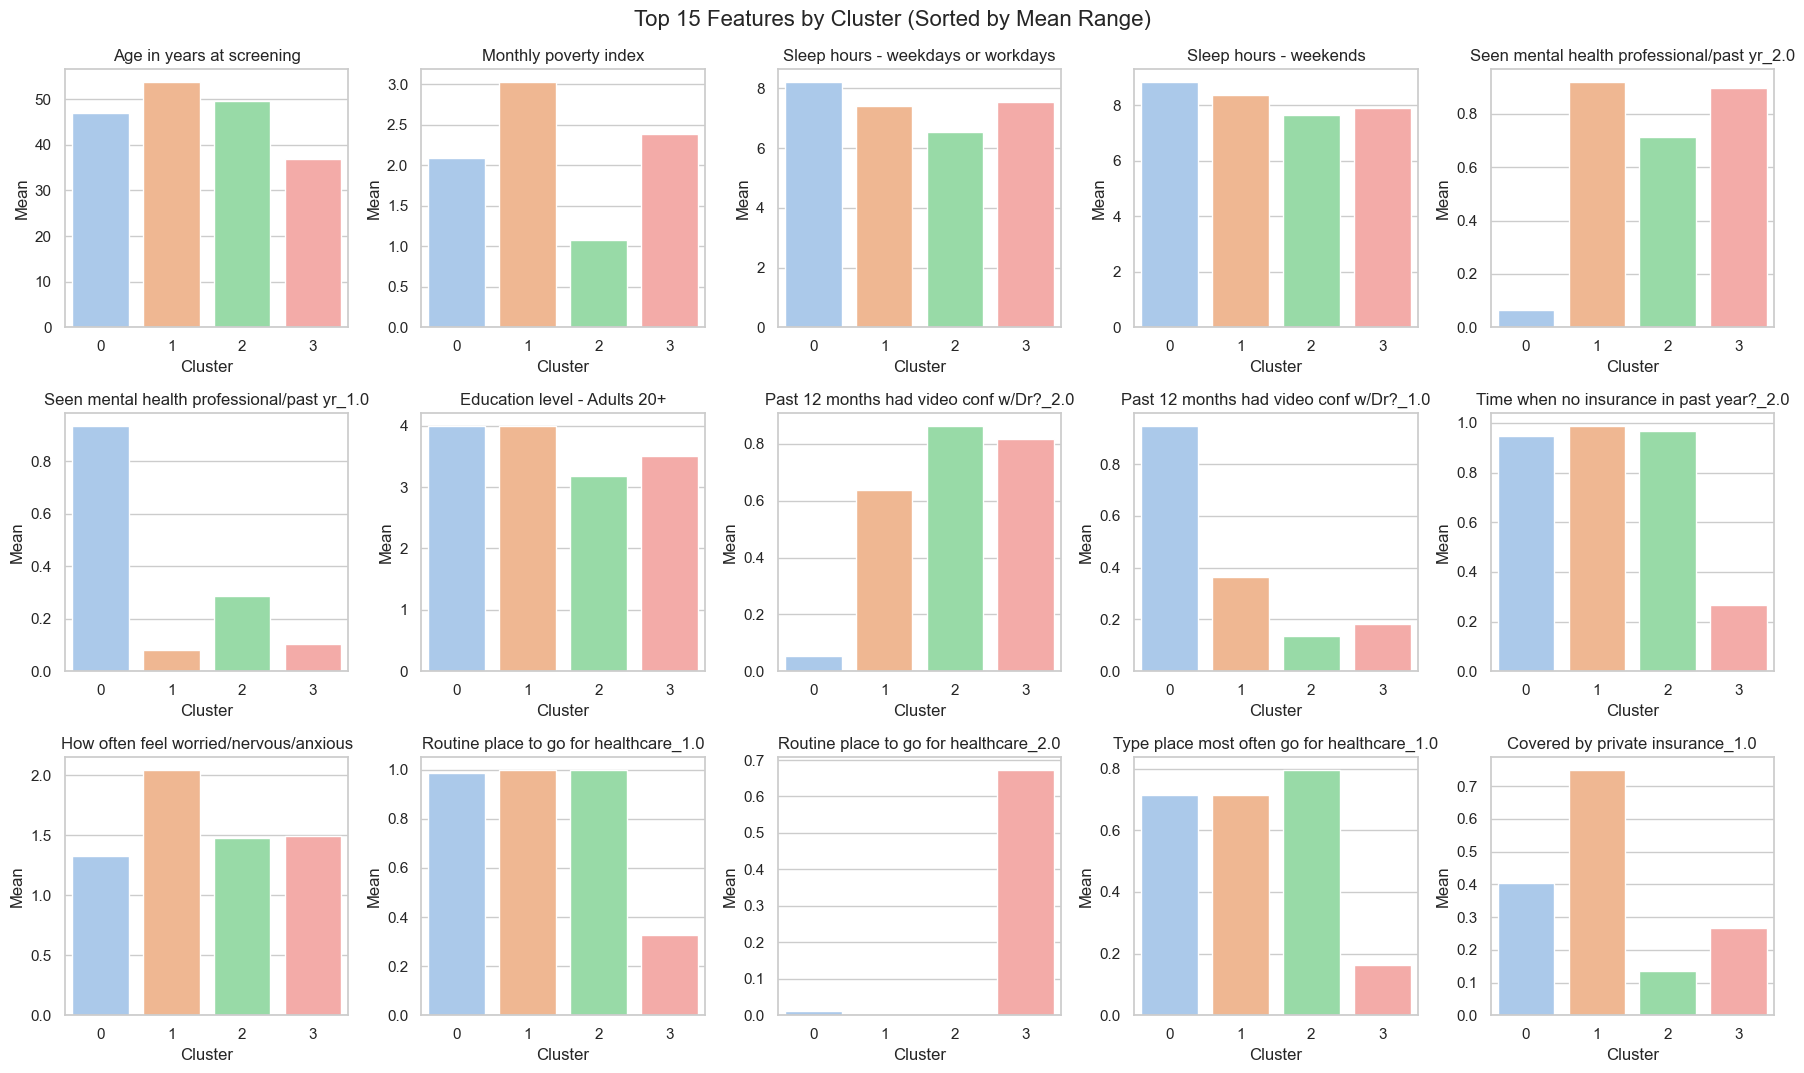

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Compute feature means by cluster
means = df_drop_labeled.groupby("Cluster_ID").mean()

# Exclude PHQ9_TOTAL if treating it as an outcome
feature_means = means.drop(columns="PHQ9_TOTAL")

# Compute range (max - min) across clusters for each feature
mean_range = feature_means.max() - feature_means.min()

# Select top 15 features by range
top_features = mean_range.sort_values(ascending=False).head(15).index.tolist()

# Determine subplot grid layout
n = len(top_features)
cols = 5
rows = math.ceil(n / cols)

# Create subplot grid
fig, axes = plt.subplots(rows, cols, figsize=(18, 3.5 * rows), sharey=False)

for i, feature in enumerate(top_features):
    ax = axes[i // cols, i % cols]
    sns.barplot(data=means.reset_index(), x="Cluster_ID", y=feature, ax=ax, palette="pastel")
    ax.set_title(feature)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Mean")

# Clean up empty subplots
for j in range(n, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()
plt.suptitle("Top 15 Features by Cluster (Sorted by Mean Range)", y=1.02, fontsize=16)
plt.show()


### Top 15 Feature Patterns by Cluster (Drop Version)

This chart presents the 15 most informative features, sorted by their mean range across clusters. The goal is to highlight features that show the strongest variation and therefore help distinguish cluster membership.

- **Age and poverty index** show clear gradients. Cluster 1 is oldest and reports the highest poverty, while Cluster 3 is youngest and lower on both metrics.

- **Sleep patterns** separate the groups. Cluster 3 gets the most sleep on both weekdays and weekends. Cluster 2 gets the least overall.

- **Mental health service use** varies. Cluster 0 has the highest average for seeing a mental health professional. Cluster 3 is lower in formal service use but high in alternate modes like video visits.

- **Healthcare access** features help split the groups. Clusters 0 and 1 report higher rates of having a regular care site. Cluster 3 is more likely to choose “other” or less conventional facilities.

- **Worry frequency and education level** also contribute. Cluster 1 reports higher anxiety levels and relatively high education. Cluster 2 is slightly lower on education but shows higher use of online care.

- **Insurance and access disruptions** appear relevant. Cluster 0 and 1 have more stable insurance, while Cluster 3 shows some fluctuation and lower private insurance coverage.

These clusters reflect distinct profiles of depression severity, health service access, and daily behaviors. The sorting by mean range helps emphasize which variables vary most across groups and may offer signals of population segmentation.


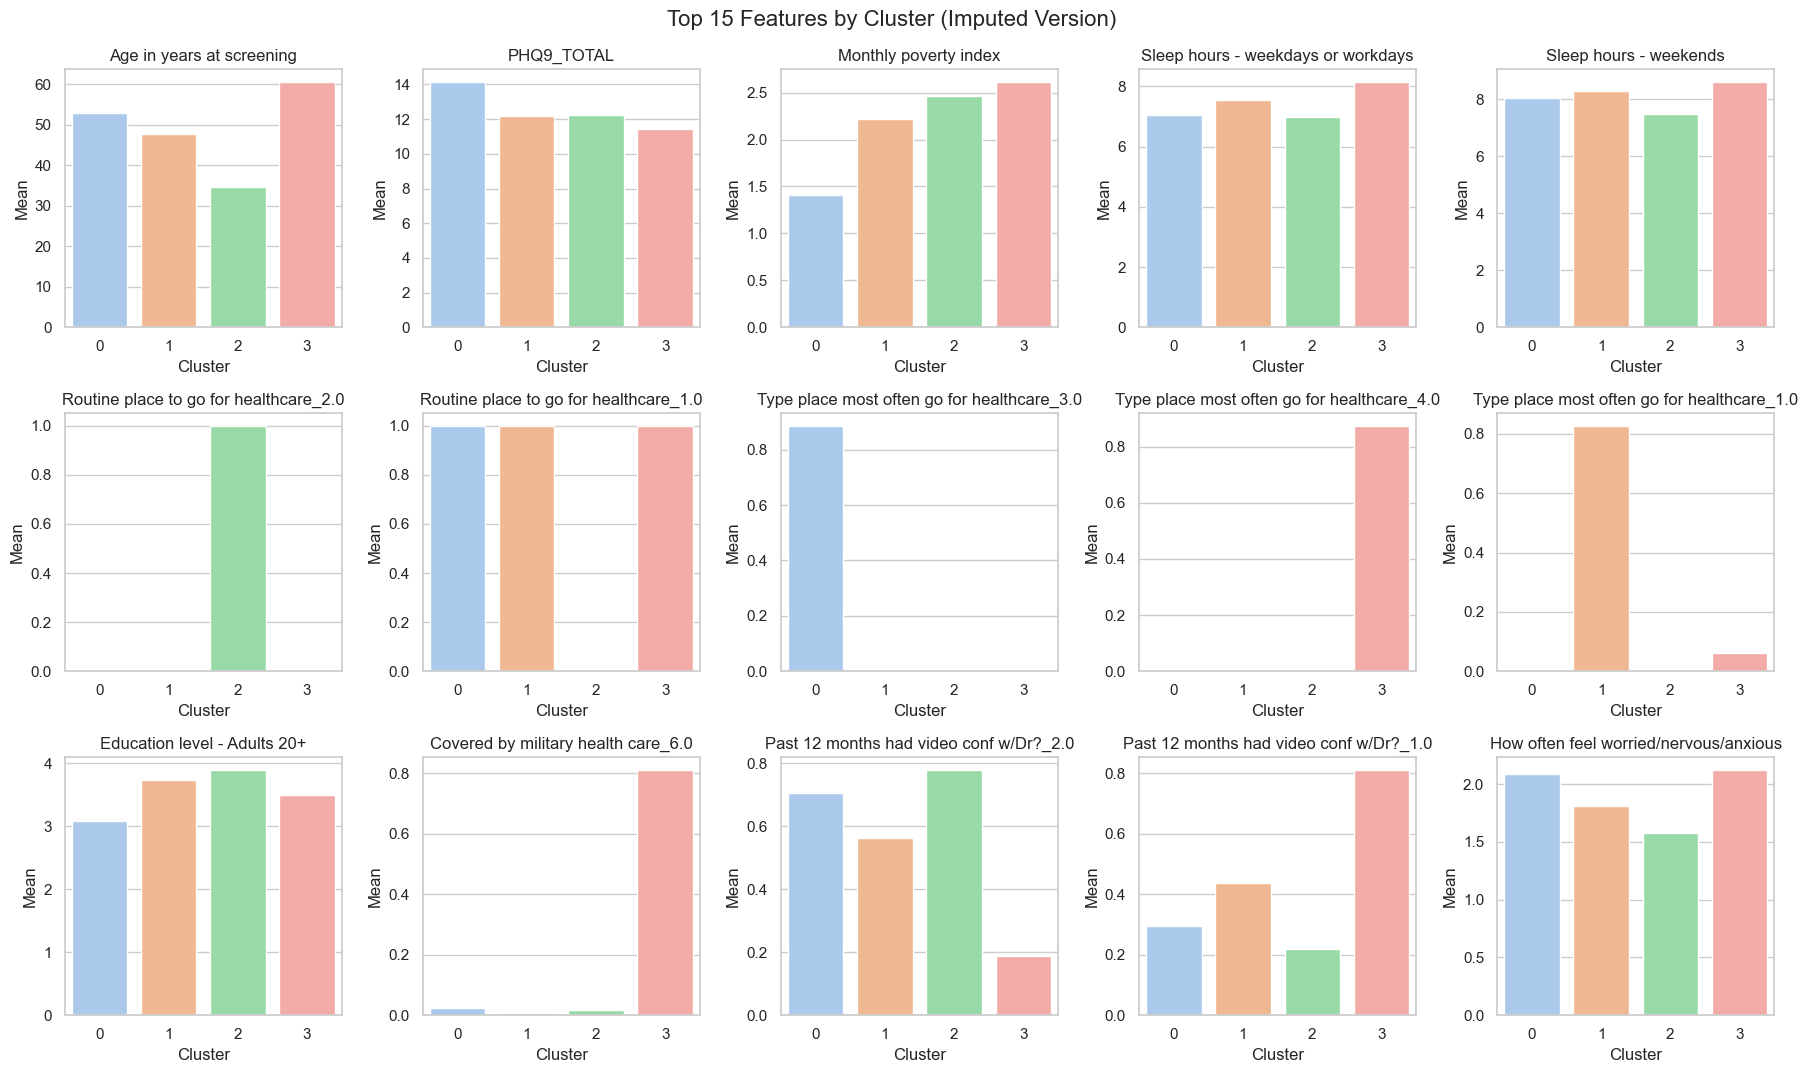

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Calculate cluster means for the imputed version
means_impute = df_impute_labeled.groupby("Cluster_ID").mean()

# Get top 15 features by range across cluster means
top_features_impute = (means_impute.max() - means_impute.min()).sort_values(ascending=False).head(15).index.tolist()

# Determine subplot grid layout
n = len(top_features_impute)
cols = 5
rows = math.ceil(n / cols)

# Plot subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 3.5 * rows), sharey=False)

for i, feature in enumerate(top_features_impute):
    ax = axes[i // cols, i % cols]
    sns.barplot(data=means_impute.reset_index(), x="Cluster_ID", y=feature, ax=ax, palette="pastel")
    ax.set_title(feature)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Mean")

# Remove empty subplots if needed
for j in range(n, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()
plt.suptitle("Top 15 Features by Cluster (Imputed Version)", y=1.02, fontsize=16)
plt.show()


### Top 15 Feature Patterns by Cluster (Imputed Version)

This chart shows how the top 15 features vary across the four clusters from the imputed dataset. Features were ranked by standard deviation in cluster means to highlight variables that contribute most to group separation.

- **Age and PHQ-9 scores** help define some clusters. Cluster 3 has the highest average age, while Cluster 2 is the youngest. Cluster 0 has slightly higher PHQ-9 scores than the other groups, though the differences are more modest than in the drop version.

- **Poverty index and education** show moderate contrast. Clusters 2 and 3 report higher poverty levels. Cluster 2 has the highest average education level, while Cluster 0 is slightly lower than others.

- **Sleep and worry levels** are fairly consistent across clusters, but Cluster 3 reports slightly more hours of sleep and higher worry levels.

- **Healthcare access and use** is a major separator. Clusters 0 and 1 have more participants using the same place for care, while Cluster 2 favors “other” or alternate care types. Cluster 2 also has higher telehealth use (video visits), and Cluster 3 shows more military healthcare coverage.

- **Binary indicators** show sharp distinctions for some features. For example, Cluster 2 has a strong presence of respondents with “routine place = 2.0,” and Cluster 3 stands out with “type of place = 4.0” and military care.

These clusters reflect differences in how people navigate healthcare systems and the varied social and behavioral contexts associated with depression risk.


### Side-by-Side Comparison of Top 15 Features (Drop vs. Imputed Versions)

This table compares the top 15 features that most clearly separate clusters in each version of the dataset. Features are sorted by the variability of their average values across clusters (mean range). While there is some overlap, differences reflect how missing data handling affects which variables show the strongest segmentation.

| Rank | Drop Version Feature                        | Imputed Version Feature                         |
|------|---------------------------------------------|-------------------------------------------------|
| 1    | Age in years at screening                   | Age in years at screening                       |
| 2    | Monthly poverty index                       | PHQ9_TOTAL                                      |
| 3    | Sleep hours - weekdays or workdays          | Monthly poverty index                           |
| 4    | Sleep hours - weekends                      | Sleep hours - weekdays or workdays              |
| 5    | Seen mental health professional/past yr_2.0 | Sleep hours - weekends                          |
| 6    | Seen mental health professional/past yr_1.0 | Routine place to go for healthcare_2.0          |
| 7    | Education level - Adults 20+                | Routine place to go for healthcare_1.0          |
| 8    | Past 12 months had video conf w/Dr?_1.0     | Type place most often go for healthcare_3.0     |
| 9    | Past 12 months had video conf w/Dr?_2.0     | Type place most often go for healthcare_4.0     |
| 10   | Time when no insurance in past year?_2.0    | Type place most often go for healthcare_1.0     |
| 11   | How often feel worried/nervous/anxious      | Education level – Adults 20+                    |
| 12   | Routine place to go for healthcare_1.0      | Covered by military health care_6.0             |
| 13   | Routine place to go for healthcare_2.0      | Past 12 months had video conf w/Dr?_2.0         |
| 14   | Type place most often go for healthcare_1.0 | Past 12 months had video conf w/Dr?_1.0         |
| 15   | Covered by private insurance_1.0            | How often feel worried/nervous/anxious          |

This comparison shows that some features, such as **age, sleep, and care access**, consistently separate clusters across both versions. Others vary depending on how missing data is handled. The drop version emphasizes **mental health service use and insurance coverage**, while the imputed version gives more weight to **facility type and healthcare access structure**.


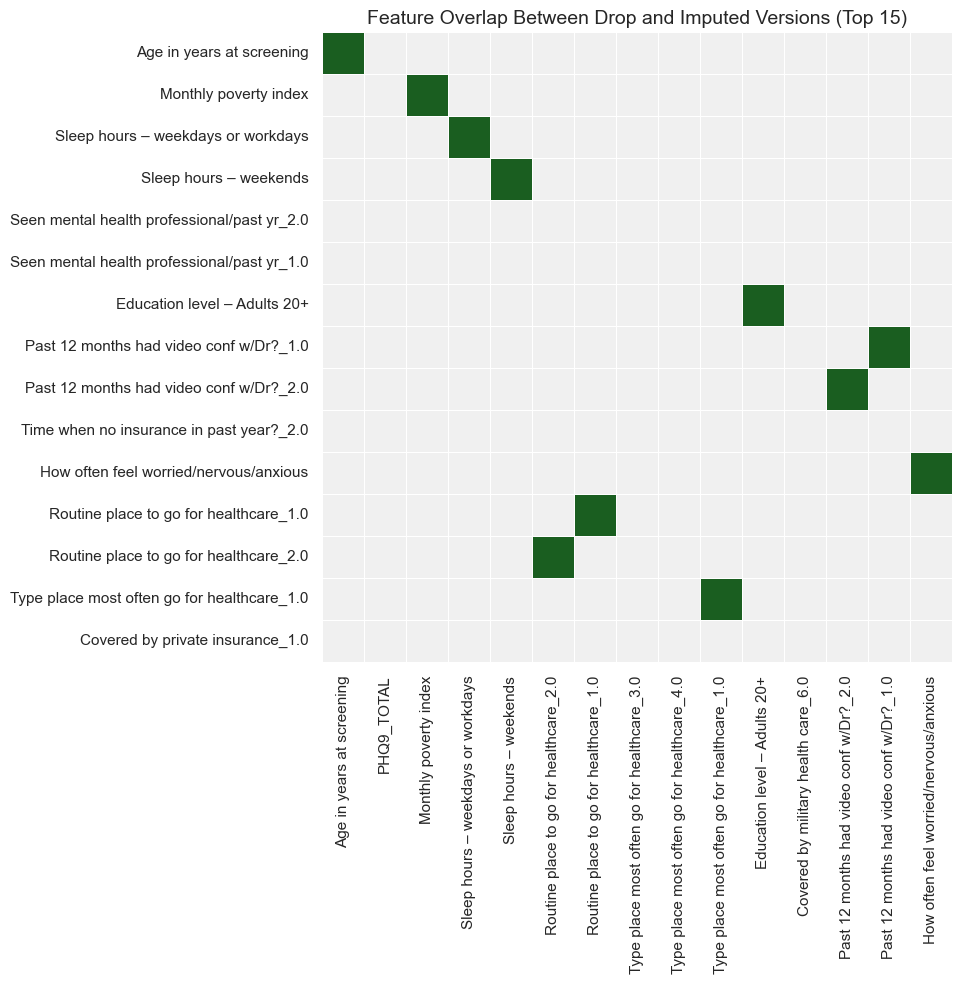

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the color map: light gray (0) and dark green (1)
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#f0f0f0", "#1a5e20"])  # light gray and dark green

# Feature lists from both rankings
drop_features = [
    "Age in years at screening",
    "Monthly poverty index",
    "Sleep hours – weekdays or workdays",
    "Sleep hours – weekends",
    "Seen mental health professional/past yr_2.0",
    "Seen mental health professional/past yr_1.0",
    "Education level – Adults 20+",
    "Past 12 months had video conf w/Dr?_1.0",
    "Past 12 months had video conf w/Dr?_2.0",
    "Time when no insurance in past year?_2.0",
    "How often feel worried/nervous/anxious",
    "Routine place to go for healthcare_1.0",
    "Routine place to go for healthcare_2.0",
    "Type place most often go for healthcare_1.0",
    "Covered by private insurance_1.0"
]

impute_features = [
    "Age in years at screening",
    "PHQ9_TOTAL",
    "Monthly poverty index",
    "Sleep hours – weekdays or workdays",
    "Sleep hours – weekends",
    "Routine place to go for healthcare_2.0",
    "Routine place to go for healthcare_1.0",
    "Type place most often go for healthcare_3.0",
    "Type place most often go for healthcare_4.0",
    "Type place most often go for healthcare_1.0",
    "Education level – Adults 20+",
    "Covered by military health care_6.0",
    "Past 12 months had video conf w/Dr?_2.0",
    "Past 12 months had video conf w/Dr?_1.0",
    "How often feel worried/nervous/anxious"
]

# Create binary match matrix
overlap_matrix = pd.DataFrame(0, index=drop_features, columns=impute_features)
for i, df in enumerate(drop_features):
    for j, imp in enumerate(impute_features):
        if df == imp:
            overlap_matrix.iloc[i, j] = 1

# Plot heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(
    overlap_matrix,
    cmap=cmap,
    linewidths=0.5,
    linecolor="white",
    cbar=False,
    xticklabels=True,
    yticklabels=True,
    square=True
)

plt.title("Feature Overlap Between Drop and Imputed Versions (Top 15)", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Feature Overlap Between Drop and Imputed Versions

This heatmap compares the top 15 features ranked by importance in both the drop-based and imputed clustering results. Each green square marks a feature that appears in the same rank position across both versions.

- Several key variables appear in both lists, including **age**, **poverty index**, **weekday and weekend sleep**, and whether someone **saw a mental health professional**. These shared features suggest consistency in the clustering results, even though the missing data was handled differently.

- A few features only show up in one version. For example, the **PHQ-9 score** appears in the imputed version but not the drop version, likely because imputation preserved more complete data for that variable.

- Some access-related features like **routine care location** or **type of provider used** show up in both versions but at different ranks, reflecting subtle differences in how the clusters formed.

This visual helps show that while the details shift, both methods point to similar patterns in how health, behavior, and access factors relate to depression risk. It strengthens confidence that the findings are not just artifacts of how missing data was handled.


---

### Preparing for Supervised Learning

Having explored natural groupings in the data using K-Means clustering, the next step is to develop supervised learning models to predict depression severity. These models will use the same cleaned and encoded dataset, building on insights from the clustering phase.

Key goals of supervised learning in this context:

- Assess whether specific features can predict mental health outcomes
- Compare model performance using both the drop and imputed versions of the data
- Translate unsupervised insights into predictive modeling tasks

The supervised learning workflow will include:

- Defining the prediction target (e.g., binary depression risk based on PHQ-9 score thresholds)
- Splitting data into training and testing sets
- Selecting and training appropriate classification models
- Evaluating performance using metrics such as accuracy, precision, recall, F1-score, and AUC
- Interpreting feature importance to understand drivers of prediction

While clustering helped uncover patterns and subgroups in the data, supervised learning helps test how well those patterns generalize. This combination strengthens the overall analysis and provides a more complete picture of depression risk in the sample.
